In [2]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [3]:
#normalizing the data

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [4]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [6]:
#K-fold validation

import numpy as np
k=4
num_val_samples = len(train_data) // k   #// is the  division operator, if total 404 then here 404/4 is 101.
num_epochs = 100
all_scores = []



for i in range(k):
    print('Processing Fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                        train_data[(i + 1) * num_val_samples:]],
                                        axis=0)
    
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                           train_targets[(i + 1) * num_val_samples:]],
                                           axis=0)
    
    model = build_model()
    
    # using a batch size of 1 (i.e., stochastic gradient descent). 
    #The verbose=0 argument is used to suppress the output of training progress during each epoch.
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing Fold # 0
Processing Fold # 1
Processing Fold # 2
Processing Fold # 3


In [7]:
print(all_scores)
print(np.mean(all_scores))


[1.970015525817871, 2.7839906215667725, 2.7853214740753174, 2.6402952671051025]
2.544905722141266


In [9]:
num_epochs = 300
all_mae_histories = []


for i in range(k):
    print('Processing Fold #', i)
    
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                        train_data[(i + 1) * num_val_samples:]],
                                        axis=0)

    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                           train_targets[(i + 1) * num_val_samples:]],
                                           axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                      validation_data=(val_data, val_targets),
                      epochs=num_epochs, batch_size=1, verbose=0)
    
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Processing Fold # 0
Processing Fold # 1
Processing Fold # 2
Processing Fold # 3


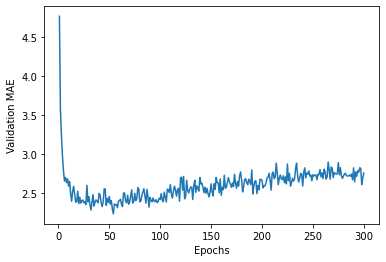

In [10]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

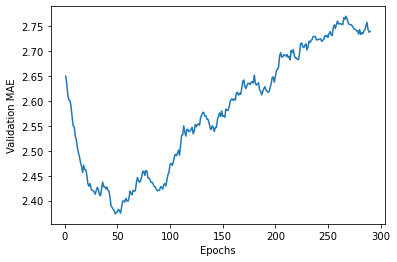

In [13]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []

    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [14]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mae_score)

4/4 [==============================] - 0s 2ms/step - loss: 18.6472 - mae: 2.7184
2.718369960784912
